# Imports

In [1]:
import sys
from pathlib import Path
import pandas as pd
from datetime import datetime, timedelta
import logging

# COMPREHENSIVE LOGGING SUPPRESSION - Set this BEFORE any imports
logging.disable(logging.INFO)  # This disables all INFO and below messages

# Add the project root to Python path
project_root = Path.cwd().parent  # Adjust this path to your project root
sys.path.insert(0, str(project_root))

from src.data.storage.database import get_db_manager
from src.dashboard.services.data_service import get_data_service

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.ticker import FixedLocator, FixedFormatter
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import seaborn as sns
from typing import Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

print("All imports successful!")
print(f"PyTorch version: {torch.__version__}")
print(f"Device: {'GPU' if torch.cuda.is_available() else 'CPU'}")

from scipy import stats
import math

All imports successful!
PyTorch version: 2.7.0+cu128
Device: GPU


# Load Data

In [2]:
def get_all_stock_data_and_info():
    """
    Get all stock data and stock info in DataFrames.
    
    Returns:
        tuple: (stock_data_df, stock_info_df, symbols_list)
    """
    try:
        # Initialize services
        db_manager = get_db_manager()
        data_service = get_data_service()
        
        # Get all available symbols (returns list of dicts with 'symbol' and 'company_name' keys)
        symbols_data = data_service.get_available_symbols()
        symbols = [item['symbol'] for item in symbols_data]  # Extract just the symbol strings
        print(f"Found {len(symbols)} symbols with data")
        
        # Get stock info for all symbols
        stock_info_list = []
        for symbol in symbols:
            try:
                stock_info = db_manager.get_stock_info(symbol)
                if stock_info:
                    stock_info_list.append(stock_info)
            except Exception as e:
                print(f"Failed to get stock info for {symbol}: {e}")
                continue
        
        # Create stock info DataFrame
        stock_info_df = pd.DataFrame(stock_info_list)
        if not stock_info_df.empty:
            print(f"Retrieved stock info for {len(stock_info_df)} symbols")
        
        # Get market data for all symbols (last 30 days for efficiency)
        all_market_data = []
        for symbol in symbols:
            try:
                # Get last 30 days of data for each symbol
                #df = data_service.get_market_data(symbol, days=30, hourly=True)
                df = data_service.get_all_market_data(symbol, hourly=True)
                if not df.empty:
                    all_market_data.append(df)
                    #print(f"Retrieved {len(df)} records for {symbol}")
            except Exception as e:
                print(f"Error getting data for {symbol}: {e}")
        
        # Combine all market data
        if all_market_data:
            stock_data_df = pd.concat(all_market_data, ignore_index=True)
            print(f"Combined market data: {len(stock_data_df)} total records")
        else:
            stock_data_df = pd.DataFrame()
            print("No market data retrieved")
        
        return stock_data_df, stock_info_df, symbols
        
    except Exception as e:
        print(f"Error: {e}")
        return pd.DataFrame(), pd.DataFrame(), []

In [3]:
# Usage example:
print("Fetching all stock data and info...")
stock_data_df, stock_info_df, symbols = get_all_stock_data_and_info()

Fetching all stock data and info...
Found 1057 symbols with data
Retrieved stock info for 1057 symbols
Combined market data: 1870119 total records


In [4]:
# Display results
print("\n" + "="*50)
print("STOCK DATA SUMMARY:")
print("="*50)
if not stock_data_df.empty:
    print(f"Market data shape: {stock_data_df.shape}")
    print(f"Date range: {stock_data_df['timestamp'].min()} to {stock_data_df['timestamp'].max()}")
    print(f"Symbols in data: {stock_data_df['symbol'].nunique()}")
    #print("\nSample market data:")
    #print(stock_data_df.head())
else:
    print("No market data available")

print("\n" + "="*50)
print("STOCK INFO SUMMARY:")
print("="*50)
if not stock_info_df.empty:
    print(f"Stock info shape: {stock_info_df.shape}")
    print(f"Available sectors: {stock_info_df['sector'].nunique()}")
    print(f"Available industries: {stock_info_df['industry'].nunique()}")
    #print("\nSample stock info:")
    #print(stock_info_df.head())
else:
    print("No stock info available")

print(f"\nTotal symbols found: {len(symbols)}")


STOCK DATA SUMMARY:
Market data shape: (1870119, 8)
Date range: 2024-08-02 08:00:00 to 2025-08-08 14:00:00
Symbols in data: 1057

STOCK INFO SUMMARY:
Stock info shape: (1057, 12)
Available sectors: 11
Available industries: 131

Total symbols found: 1057


# Analysis

In [5]:
# Visualization basics
%matplotlib inline

fig_path = r'D:\PythonProjects\MLTrading\notebooks\fig'  


def pred_color_presentation(c):
    custom_palette_presentation = {
        'midnight-blue': '#191970',
        'forest-green': '#228B22',
        'muted-gold': '#B8860B',
        'light-gray': '#D3D3D3',
        'sea-green': '#2E8B57',
        'teal-green': '#008080',
        'highlight': '#C19A6B',
        'black': '#000000',
        'color1':'#dfdfdf',
        'color2':'#dfb834',
        'color3':'#f1f6db',
        'color4':'#649e92',
        'color5':'#a13d61',
    }
    return custom_palette_presentation.get(c, "Invalid color name")

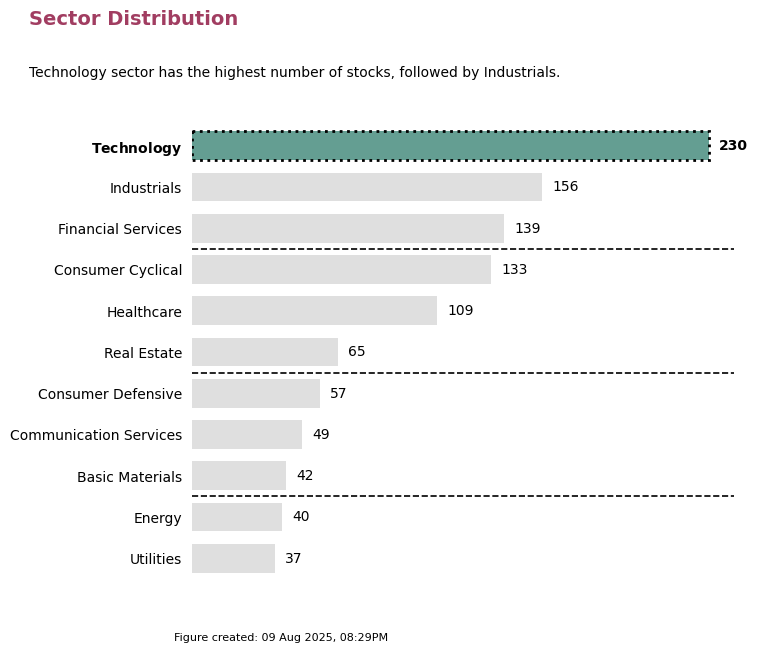

In [6]:
import datetime
# Get current date and time
now = datetime.datetime.now()
formatted_date_time = now.strftime("%d %b %Y, %I:%M%p") 

# Prepare unique sector counts
temp_df = stock_info_df[['symbol', 'sector']].drop_duplicates()
sector_counts = temp_df['sector'].value_counts().sort_values(ascending=False)

# Identify the sector with the highest count
max_index = sector_counts.idxmax()

# Define colors based on the highest count
colors = [pred_color_presentation('color1') if sector != max_index else pred_color_presentation('color4') for sector in sector_counts.index]

# Create a horizontal bar chart with highest at the top
ax = sector_counts.plot(kind='barh', figsize=(7, 6), width=0.7, color=colors)

# Reverse the order so the highest value appears at the top
ax.invert_yaxis()

# Keep y-labels but remove y-ticks
ax.set_yticks(range(len(sector_counts)))

# Make y-labels and bold the one for max industry
yticklabels = []
for sector in sector_counts.index:
    if sector == max_index:
        yticklabels.append(f"$\\bf{{{sector}}}$")
    else:
        yticklabels.append(sector)
ax.set_yticklabels(yticklabels, fontsize=10)

ax.tick_params(left=False)

# Add margin space between labels and bars
ax.margins(y=0.1)

# Add horizontal lines to group pairs of three
for i in range(3, len(sector_counts), 3):
    ax.axhline(y=i - 0.5, color='black', linestyle='dashed', linewidth=1.2)

# Customize the chart
ax.set_xlabel('Number of Stocks')
ax.set_ylabel('')
ax.set_xticklabels([])  
ax.xaxis.set_visible(False)  
ax.grid(axis='x', linestyle='none')
ax.grid(axis='y', linestyle='none')

# Remove unnecessary spines
for spine in ['right', 'top', 'bottom', 'left']:
    ax.spines[spine].set_visible(False)

# Get bar positions for count labels
bar_containers = ax.containers  
bar_y_positions = [rect.get_y() + rect.get_height() / 2 for rect in bar_containers[0]]

# Add count labels with bold for the highest count
for count, y_pos, sector in zip(sector_counts, bar_y_positions, sector_counts.index):
    fontweight = 'bold' if sector == max_index else 'normal'
    ax.text(
        count + max(sector_counts) * 0.02,
        y_pos,
        str(count),
        va='center',
        ha='left',
        fontsize=10,
        fontweight=fontweight
    )

# Add a dotted border around the bar with the highest count
for rect, sector in zip(bar_containers[0], sector_counts.index):
    if sector == max_index:
        x = rect.get_x()
        y = rect.get_y()
        width = rect.get_width()
        height = rect.get_height()

        dotted_rect = patches.Rectangle(
            (x, y),
            width,
            height,
            linewidth=2,
            edgecolor='black',
            facecolor='none',
            linestyle='dotted'
        )
        ax.add_patch(dotted_rect)
        break

# Add annotation for the highest industry
plt.annotate(
    'Sector Distribution', 
    xy=(-0.3, 1.2), 
    xycoords='axes fraction', 
    fontsize=14, 
    fontweight='bold',
    ha='left', 
    va='bottom',
    color=pred_color_presentation('color5')
)

plt.annotate(
    f'{sector_counts.index[0]} sector has the highest number of stocks, followed by {sector_counts.index[1]}.', 
    xy=(-0.3, 1.09), 
    xycoords='axes fraction', 
    fontsize=10, 
    ha='left', 
    va='bottom',
    color='black'
)

# Add footnote with date and time
plt.figtext(
    0.1,  
    0.01,  
    f"Figure created: {formatted_date_time}",
    horizontalalignment='left',
    verticalalignment='bottom',
    fontsize=8,
    color='black'
)

# Save and show the plot
fig_name = f'sector_distribution.jpg'
plt.savefig(os.path.join(fig_path, fig_name), bbox_inches='tight')
plt.show()

In [7]:
selected_sector = 'Utilities'
selected_sector_symbols = stock_info_df['symbol'][stock_info_df['sector'] == selected_sector]
#selected_sector_symbols =['AEE', 'AEP', 'AES', 'ATO']
#selected_sector_symbols =['AEE', 'AEP']
ohlc_df = stock_data_df[stock_data_df['symbol'].isin(selected_sector_symbols)]
ohlc_df = ohlc_df.drop(columns=['source'])

# Explore the Data

In [8]:
print("Basic statistics by symbol:")
print(ohlc_df.groupby('symbol')[['open', 'high', 'low', 'close', 'volume']].describe())

Basic statistics by symbol:
          open                                                        \
         count        mean        std       min        25%       50%   
symbol                                                                 
AEE     1773.0   92.918449   5.994177   79.7700   87.96500   94.6350   
AEP     1773.0  101.482701   4.917305   90.1000   98.15000  101.7500   
AES     1773.0   13.350469   2.860851    9.5400   10.87560   12.8350   
ATO     1773.0  146.155609   9.046001  126.9900  139.12500  146.8700   
AWK     1773.0  138.512126   7.590433  119.4588  134.64500  140.7950   
BEPC    1773.0   29.734549   2.693572   24.0100   27.91000   29.1800   
CEG     1773.0  257.630941  47.921822  156.0450  218.00000  257.8300   
CMS     1773.0   69.852940   2.561286   64.1800   67.76000   69.8100   
CNP     1772.0   33.084578   3.740323   25.4550   30.02625   32.6675   
CWEN    1773.0   28.729942   1.986400   24.4600   27.29000   28.6800   
D       1773.0   56.086292   2.06871

In [9]:
selected_sector_symbols_9 = selected_sector_symbols[:9]

In [10]:
num_symbols = len(selected_sector_symbols_9)
# Determine grid size (e.g., 3 columns)
cols = 3
rows = math.ceil(num_symbols / cols)

In [11]:
ohlc_9_df= ohlc_df[ohlc_df['symbol'].isin(selected_sector_symbols_9)]

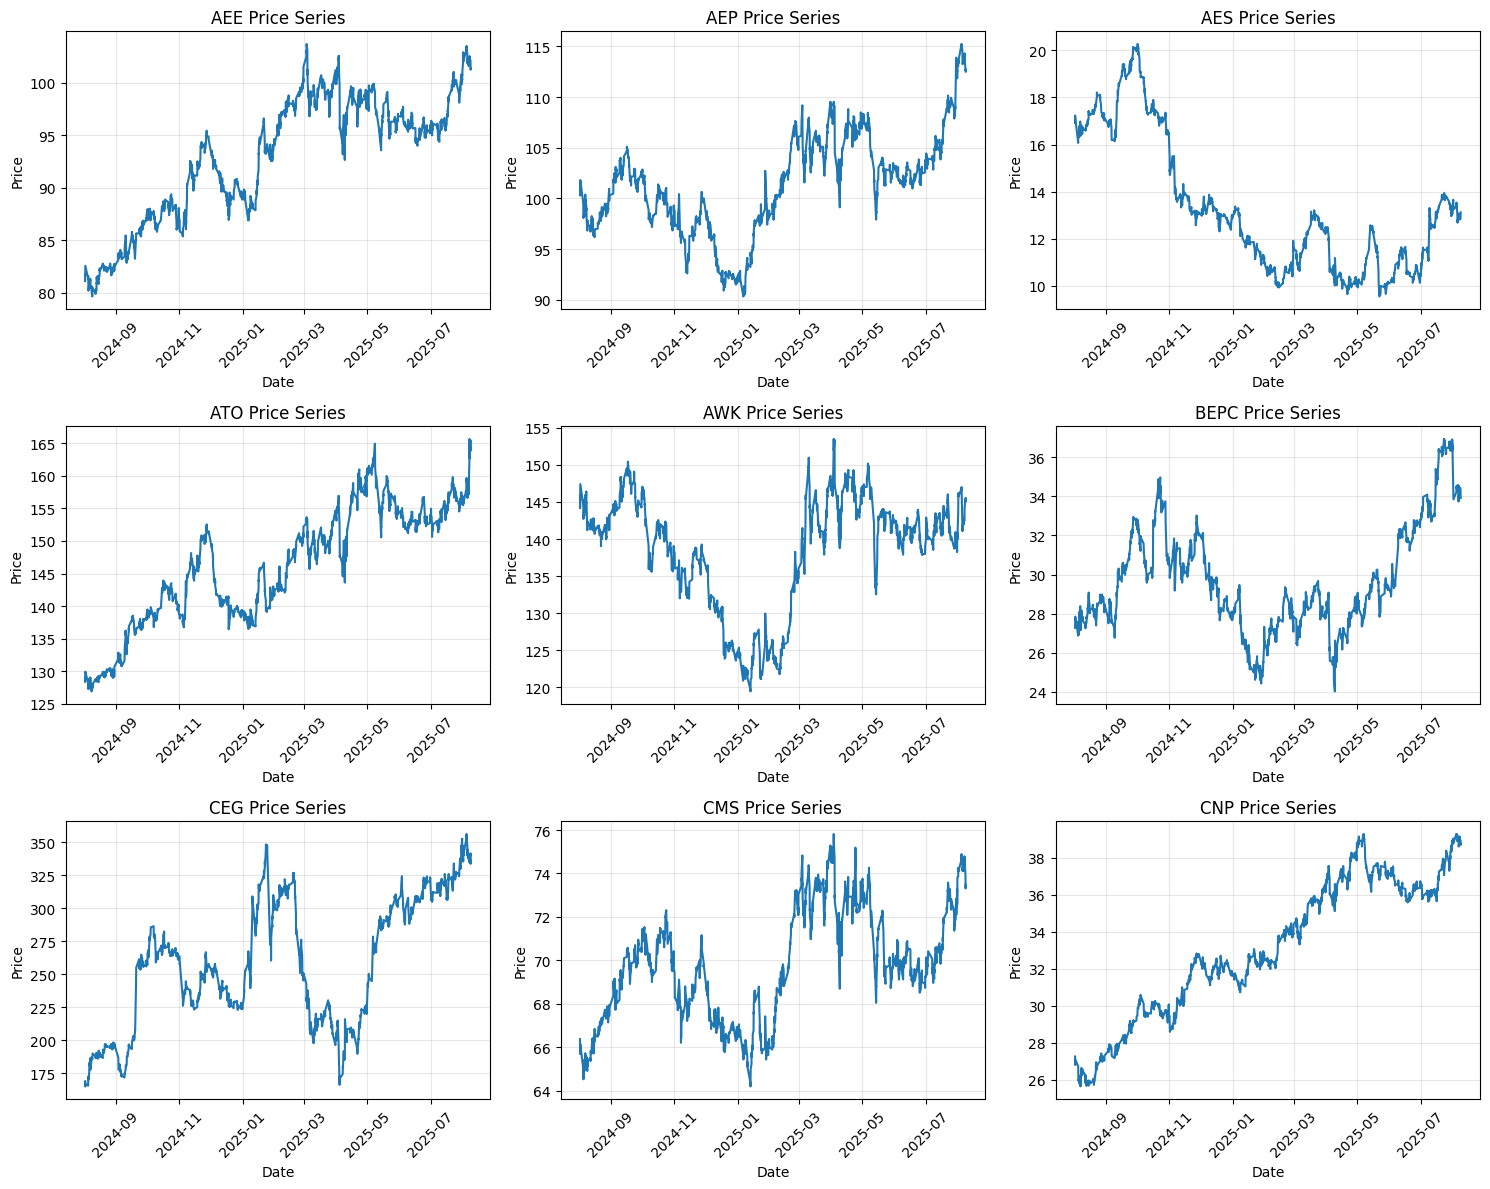

In [12]:
# Plot price series for all symbols
#fig, axes = plt.subplots(4, figsize=(15, 10))
fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows), squeeze=False)
axes = axes.flatten()

for i, symbol in enumerate(ohlc_9_df['symbol'].unique()):
    symbol_data = ohlc_9_df[ohlc_9_df['symbol'] == symbol].copy()
    symbol_data = symbol_data.sort_values('timestamp')
    
    axes[i].plot(symbol_data['timestamp'], symbol_data['close'], label=f'{symbol} Close Price')
    axes[i].set_title(f'{symbol} Price Series')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Price')
    axes[i].grid(True, alpha=0.3)
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Feature Engineering

## Configuration and Parameters

In [13]:
# Window sizes for hourly data
SHORT_WINDOW = 24        # 1 day
MED_WINDOW = 120         # 5 days  
LONG_WINDOW = 480        # 20 days
VOL_WINDOWS = [12, 24, 120]  # 12h, 1d, 5d

RSI_WINDOWS = {
    'rsi_1d': 24,        # 1 day
    'rsi_3d': 72,        # 3 days
    'rsi_1w': 168,       # 1 week
    'rsi_2w': 336        # 2 weeks
}

LAG_PERIODS = [1, 2, 4, 8, 24]  # 1h, 2h, 4h, 8h, 1day
ROLLING_WINDOWS = [6, 12, 24]   # 6h, 12h, 24h windows

print("Parameters configured:")
print(f"Short window: {SHORT_WINDOW} hours")
print(f"Medium window: {MED_WINDOW} hours")
print(f"Long window: {LONG_WINDOW} hours")

Parameters configured:
Short window: 24 hours
Medium window: 120 hours
Long window: 480 hours


## Basic Price Features

In [14]:
def add_basic_price_features(group):
    """Add basic price-derived features"""
    #print(f"Processing basic features for {group['symbol'].iloc[0]}...")
    
    # Basic price features
    group['returns'] = group['close'].pct_change()
    group['log_returns'] = np.log(group['close'] / group['close'].shift(1))
    group['high_low_pct'] = (group['high'] - group['low']) / group['close']
    group['open_close_pct'] = (group['close'] - group['open']) / group['open']
    
    # Price momentum features
    group['price_acceleration'] = group['returns'].diff()  # Second derivative of price
    group['returns_sign'] = np.sign(group['returns'])  # Direction indicator
    
    return group

In [15]:
# Test with a sample
sample_df = ohlc_df[ohlc_df['symbol'] == ohlc_df['symbol'].unique()[0]].copy()
sample_df = add_basic_price_features(sample_df)
print("Basic price features added:", sample_df.columns.tolist()[-6:])

Basic price features added: ['returns', 'log_returns', 'high_low_pct', 'open_close_pct', 'price_acceleration', 'returns_sign']


## Enhanced Volatility Features

In [16]:
def add_volatility_features(group):
    """Add multiple volatility estimators"""
    #print(f"Adding volatility features for {group['symbol'].iloc[0]}...")
    
    # Basic volatility features
    group['returns_squared'] = group['returns'] ** 2
    group['realized_vol_short'] = group['returns'].rolling(VOL_WINDOWS[0]).std()
    group['realized_vol_med'] = group['returns'].rolling(VOL_WINDOWS[1]).std()
    group['realized_vol_long'] = group['returns'].rolling(VOL_WINDOWS[2]).std()
    
    # Garman-Klass volatility estimator (more efficient for OHLC data)
    gk_vol = (np.log(group['high']/group['low'])**2 - 
              (2*np.log(2)-1)*np.log(group['close']/group['open'])**2)
    group['gk_volatility'] = np.sqrt(gk_vol.rolling(24).mean())  # 1-day window
    
    # Volatility of volatility (important for regime detection)
    group['vol_of_vol'] = group['realized_vol_short'].rolling(24).std()
    
    return group

In [17]:
# Test volatility features
sample_df = add_volatility_features(sample_df)
print("Volatility features added")

Volatility features added


## Moving Average Features

In [18]:
def add_moving_average_features(group):
    """Add moving averages and related ratios"""
    #print(f"Adding moving average features for {group['symbol'].iloc[0]}...")
    
    # Moving averages
    group['price_ma_short'] = group['close'].rolling(SHORT_WINDOW).mean()
    group['price_ma_med'] = group['close'].rolling(MED_WINDOW).mean()
    group['price_ma_long'] = group['close'].rolling(LONG_WINDOW).mean()
    
    # Price to moving average ratios
    group['price_to_ma_short'] = group['close'] / group['price_ma_short']
    group['price_to_ma_med'] = group['close'] / group['price_ma_med']
    group['price_to_ma_long'] = group['close'] / group['price_ma_long']
    
    # Moving average convergence/divergence ratios
    group['ma_short_to_med'] = group['price_ma_short'] / group['price_ma_med']
    group['ma_med_to_long'] = group['price_ma_med'] / group['price_ma_long']
    
    return group

In [19]:
# Test moving average features
sample_df = add_moving_average_features(sample_df)
print("Moving average features added")

Moving average features added


## Volume Features

In [20]:
def add_volume_features(group):
    """Add volume-based features"""
    #print(f"Adding volume features for {group['symbol'].iloc[0]}...")
    
    # Basic volume features
    group['volume_ma'] = group['volume'].rolling(MED_WINDOW).mean()
    group['volume_ratio'] = group['volume'] / group['volume_ma']
    group['log_volume'] = np.log(group['volume'] + 1)
    
    # Volume-Price Trend (VPT) indicator
    group['vpt'] = (group['volume'] * group['returns']).cumsum()
    group['vpt_ma'] = group['vpt'].rolling(SHORT_WINDOW).mean()
    group['vpt_normalized'] = group['vpt'] / group['vpt_ma']
    
    # Money Flow Index components
    typical_price = (group['high'] + group['low'] + group['close']) / 3
    money_flow = typical_price * group['volume']
    positive_flow = money_flow.where(typical_price > typical_price.shift(1), 0)
    negative_flow = money_flow.where(typical_price < typical_price.shift(1), 0)
    
    money_ratio = (positive_flow.rolling(14).sum() / 
                  (negative_flow.rolling(14).sum() + 1e-10))
    group['mfi'] = 100 - (100 / (1 + money_ratio))
    
    return group

In [21]:
# Test volume features
sample_df = add_volume_features(sample_df)
print("Volume features added")

Volume features added


## RSI Features

In [22]:
def add_rsi_features(group):
    """Add multiple RSI timeframes"""
    #print(f"Adding RSI features for {group['symbol'].iloc[0]}...")
    
    # Multiple RSI timeframes
    for rsi_name, window in RSI_WINDOWS.items():
        delta = group['close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window).mean()
        rs = gain / (loss + 1e-10)
        group[rsi_name] = 100 - (100 / (1 + rs))
    
    # Exponential Moving Average RSI
    delta = group['close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    
    alpha = 2 / (14 + 1)
    avg_gain = gain.ewm(alpha=alpha, adjust=False).mean()
    avg_loss = loss.ewm(alpha=alpha, adjust=False).mean()
    rs_ema = avg_gain / (avg_loss + 1e-10)
    group['rsi_ema'] = 100 - (100 / (1 + rs_ema))
    
    return group

In [23]:
# Test RSI features
sample_df = add_rsi_features(sample_df)
print("RSI features added")

RSI features added


## Time-Based Features

In [24]:
def add_time_features(group):
    """Add time-based features for hourly data"""
    #print(f"Adding time features for {group['symbol'].iloc[0]}...")
    
    # Basic time features
    group['hour'] = group['timestamp'].dt.hour
    group['day_of_week'] = group['timestamp'].dt.dayofweek
    group['date'] = group['timestamp'].dt.date
    
    # Cyclical encoding for time features (better for neural networks)
    group['hour_sin'] = np.sin(2 * np.pi * group['hour'] / 24)
    group['hour_cos'] = np.cos(2 * np.pi * group['hour'] / 24)
    group['dow_sin'] = np.sin(2 * np.pi * group['day_of_week'] / 7)
    group['dow_cos'] = np.cos(2 * np.pi * group['day_of_week'] / 7)
    
    # Market session features
    group['is_market_open'] = ((group['hour'] >= 9) & (group['hour'] <= 16)).astype(int)
    group['is_morning'] = ((group['hour'] >= 9) & (group['hour'] <= 12)).astype(int)
    group['is_afternoon'] = ((group['hour'] >= 13) & (group['hour'] <= 16)).astype(int)
    group['hours_since_open'] = np.clip(group['hour'] - 9, 0, 7)
    group['hours_to_close'] = np.clip(16 - group['hour'], 0, 7)
    
    return group

In [25]:
# Test time features
sample_df = add_time_features(sample_df)
print("Time features added")

Time features added


## Intraday Features

In [26]:
def add_intraday_features(group):
    """Add intraday reference points with enhanced error handling"""
    #print(f"Adding intraday features for {group['symbol'].iloc[0]}...")
    
    try:
        daily_opens = group.groupby('date')['open'].transform('first')
        group['returns_from_daily_open'] = ((group['close'] - daily_opens) / 
                                           daily_opens).fillna(0)
        
        group['intraday_high'] = group.groupby('date')['high'].transform('max')
        group['intraday_low'] = group.groupby('date')['low'].transform('min')
        
        intraday_range = group['intraday_high'] - group['intraday_low']
        group['intraday_range_pct'] = (intraday_range / daily_opens).fillna(0)
        
        range_denominator = intraday_range.replace(0, np.nan)
        group['position_in_range'] = ((group['close'] - group['intraday_low']) / 
                                     range_denominator).fillna(0.5)
        
        prev_day_close = (group.groupby('date')['close']
                         .transform('last')
                         .shift(group.groupby('date').cumcount().max() + 1))
        group['overnight_gap'] = ((daily_opens - prev_day_close) / 
                                prev_day_close).fillna(0)
        
        group['dist_from_intraday_high'] = ((group['close'] - group['intraday_high']) / 
                                           group['intraday_high']).fillna(0)
        group['dist_from_intraday_low'] = ((group['close'] - group['intraday_low']) / 
                                          group['intraday_low']).fillna(0)
        
    except Exception as e:
        print(f"Warning: Error in intraday features for {group['symbol'].iloc[0]}: {e}")
        # Create dummy features if calculation fails
        for col in ['returns_from_daily_open', 'intraday_range_pct', 'position_in_range', 
                   'overnight_gap', 'dist_from_intraday_high', 'dist_from_intraday_low']:
            group[col] = 0 if 'gap' in col or 'range' in col or 'dist' in col else 0.5
    
    return group

In [27]:
# Test intraday features
sample_df = add_intraday_features(sample_df)
print("Intraday features added")

Intraday features added


## Lagged Features

In [28]:
def add_lagged_features(group):
    """Add lagged features for sequence modeling"""
    #print(f"Adding lagged features for {group['symbol'].iloc[0]}...")
    
    # Enhanced lagged features
    for lag in LAG_PERIODS:
        group[f'returns_lag_{lag}'] = group['returns'].shift(lag)
        group[f'vol_lag_{lag}'] = group['realized_vol_short'].shift(lag)
        group[f'volume_ratio_lag_{lag}'] = group['volume_ratio'].shift(lag)
    
    return group

In [29]:
# Test lagged features
sample_df = add_lagged_features(sample_df)
print("Lagged features added")

Lagged features added


## Rolling Statistics

In [30]:
def add_rolling_statistics(group):
    """Add rolling statistics for sequence modeling"""
    #print(f"Adding rolling statistics for {group['symbol'].iloc[0]}...")
    
    # Rolling statistics for different windows
    for window in ROLLING_WINDOWS:
        group[f'returns_mean_{window}h'] = group['returns'].rolling(window).mean()
        group[f'returns_std_{window}h'] = group['returns'].rolling(window).std()
        group[f'returns_skew_{window}h'] = group['returns'].rolling(window).skew()
        group[f'returns_kurt_{window}h'] = group['returns'].rolling(window).kurt()
        
        # Price momentum over different windows
        group[f'price_momentum_{window}h'] = (group['close'] / group['close'].shift(window) - 1)
    
    return group

In [31]:
# Test rolling statistics
sample_df = add_rolling_statistics(sample_df)
print("Rolling statistics added")

Rolling statistics added


## Technical Indicators

In [32]:
def add_technical_indicators(group):
    """Add technical indicators"""
    #print(f"Adding technical indicators for {group['symbol'].iloc[0]}...")
    
    # Bollinger Bands
    bb_window = SHORT_WINDOW
    bb_std = group['close'].rolling(bb_window).std()
    bb_mean = group['close'].rolling(bb_window).mean()
    group['bb_upper'] = bb_mean + (2 * bb_std)
    group['bb_lower'] = bb_mean - (2 * bb_std)
    group['bb_position'] = ((group['close'] - group['bb_lower']) / 
                           (group['bb_upper'] - group['bb_lower'] + 1e-10)).fillna(0.5)
    
    # Bollinger Band squeeze indicator
    group['bb_squeeze'] = (group['bb_upper'] - group['bb_lower']) / group['close']
    
    # MACD
    exp1 = group['close'].ewm(span=12).mean()
    exp2 = group['close'].ewm(span=26).mean()
    group['macd'] = exp1 - exp2
    group['macd_signal'] = group['macd'].ewm(span=9).mean()
    group['macd_histogram'] = group['macd'] - group['macd_signal']
    
    # Normalized MACD (scale-invariant)
    group['macd_normalized'] = group['macd'] / group['close']
    
    return group

In [33]:
# Test technical indicators
sample_df = add_technical_indicators(sample_df)
print("Technical indicators added")

Technical indicators added


## Advanced Technical Indicators

In [34]:
def add_advanced_technical_indicators(group):
    """Add advanced technical indicators"""
    #print(f"Adding advanced technical indicators for {group['symbol'].iloc[0]}...")
    
    # Average True Range (ATR) for volatility normalization
    high_low = group['high'] - group['low']
    high_close = np.abs(group['high'] - group['close'].shift(1))
    low_close = np.abs(group['low'] - group['close'].shift(1))
    true_range = np.maximum(high_low, np.maximum(high_close, low_close))
    group['atr'] = true_range.rolling(14).mean()
    group['atr_normalized'] = group['atr'] / group['close']
    
    # Williams %R
    highest_high = group['high'].rolling(14).max()
    lowest_low = group['low'].rolling(14).min()
    group['williams_r'] = -100 * ((highest_high - group['close']) / 
                                 (highest_high - lowest_low + 1e-10))
    
    return group

In [35]:
# Test advanced technical indicators
sample_df = add_advanced_technical_indicators(sample_df)
print("Advanced technical indicators added")

Advanced technical indicators added


## Main Feature Engineering Function

In [36]:
def engineer_features_for_symbol(group):
    """Apply all feature engineering steps to a single symbol"""
    group = group.sort_values('timestamp').copy()
    
    # Apply all feature engineering steps
    group = add_basic_price_features(group)
    group = add_volatility_features(group)
    group = add_moving_average_features(group)
    group = add_volume_features(group)
    group = add_rsi_features(group)
    group = add_time_features(group)
    group = add_intraday_features(group)
    group = add_lagged_features(group)
    group = add_rolling_statistics(group)
    group = add_technical_indicators(group)
    group = add_advanced_technical_indicators(group)
    
    return group

## Apply Feature Engineering to All Symbols

In [37]:
def engineer_features(df):
    """Create technical indicators and features from hourly OHLC data optimized for GRU embeddings"""
    
    print("Engineering features for hourly data...")
    
    # Apply feature engineering to each symbol
    results = []
    for symbol in df['symbol'].unique():
        symbol_data = df[df['symbol'] == symbol].copy()
        engineered_data = engineer_features_for_symbol(symbol_data)
        results.append(engineered_data)
    
    # Combine all results
    features_df = pd.concat(results, ignore_index=True)
    
    print(f"Feature engineering complete! Generated {len(features_df.columns)} features")
    print(f"Features: {features_df.columns.tolist()}")
    
    return features_df

In [38]:
from tqdm import tqdm

def engineer_features(df):
    """Create technical indicators and features from hourly OHLC data optimized for GRU embeddings"""
    
    print("Engineering features for hourly data...")
    
    # Apply feature engineering to each symbol with a progress bar
    results = []
    for symbol in tqdm(df['symbol'].unique(), desc="Processing symbols", unit="symbol"):
        symbol_data = df[df['symbol'] == symbol].copy()
        engineered_data = engineer_features_for_symbol(symbol_data)
        results.append(engineered_data)
    
    # Combine all results
    features_df = pd.concat(results, ignore_index=True)
    
    print(f"Feature engineering complete! Generated {len(features_df.columns)} features")
    print(f"Features: {features_df.columns.tolist()}")
    
    return features_df


In [39]:
# Apply to your data
features_df = engineer_features(ohlc_df)

Engineering features for hourly data...


Processing symbols: 100%|██████████| 37/37 [00:06<00:00,  5.73symbol/s]


Feature engineering complete! Generated 100 features
Features: ['timestamp', 'symbol', 'open', 'high', 'low', 'close', 'volume', 'returns', 'log_returns', 'high_low_pct', 'open_close_pct', 'price_acceleration', 'returns_sign', 'returns_squared', 'realized_vol_short', 'realized_vol_med', 'realized_vol_long', 'gk_volatility', 'vol_of_vol', 'price_ma_short', 'price_ma_med', 'price_ma_long', 'price_to_ma_short', 'price_to_ma_med', 'price_to_ma_long', 'ma_short_to_med', 'ma_med_to_long', 'volume_ma', 'volume_ratio', 'log_volume', 'vpt', 'vpt_ma', 'vpt_normalized', 'mfi', 'rsi_1d', 'rsi_3d', 'rsi_1w', 'rsi_2w', 'rsi_ema', 'hour', 'day_of_week', 'date', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'is_market_open', 'is_morning', 'is_afternoon', 'hours_since_open', 'hours_to_close', 'returns_from_daily_open', 'intraday_high', 'intraday_low', 'intraday_range_pct', 'position_in_range', 'overnight_gap', 'dist_from_intraday_high', 'dist_from_intraday_low', 'returns_lag_1', 'vol_lag_1', 'volume_ra

## Quality Check

In [40]:
def check_feature_quality(df):
    """Check the quality of engineered features"""
    print("Feature Quality Report:")
    print("=" * 50)
    
    # Check for NaN values
    nan_counts = df.isnull().sum()
    nan_features = nan_counts[nan_counts > 0]
    
    if len(nan_features) > 0:
        print(f"Features with NaN values:")
        for feature, count in nan_features.items():
            print(f"  {feature}: {count} NaN values ({count/len(df)*100:.1f}%)")
    else:
        print("✓ No NaN values found in any feature")
    
    # Check for infinite values
    inf_features = []
    for col in df.select_dtypes(include=[np.number]).columns:
        if np.isinf(df[col]).any():
            inf_count = np.isinf(df[col]).sum()
            inf_features.append((col, inf_count))
    
    if inf_features:
        print(f"\nFeatures with infinite values:")
        for feature, count in inf_features:
            print(f"  {feature}: {count} infinite values")
    else:
        print("✓ No infinite values found")
    
    # Feature statistics
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    print(f"\nFeature Statistics:")
    print(f"  Total features: {len(df.columns)}")
    print(f"  Numeric features: {len(numeric_cols)}")
    print(f"  Data points: {len(df)}")
    print(f"  Symbols: {df['symbol'].nunique()}")
    
    return df

In [41]:
# Check feature quality
features_df = check_feature_quality(features_df)

Feature Quality Report:
Features with NaN values:
  returns: 37 NaN values (0.1%)
  log_returns: 37 NaN values (0.1%)
  price_acceleration: 74 NaN values (0.1%)
  returns_sign: 37 NaN values (0.1%)
  returns_squared: 37 NaN values (0.1%)
  realized_vol_short: 444 NaN values (0.7%)
  realized_vol_med: 888 NaN values (1.4%)
  realized_vol_long: 4440 NaN values (6.8%)
  gk_volatility: 851 NaN values (1.3%)
  vol_of_vol: 1295 NaN values (2.0%)
  price_ma_short: 851 NaN values (1.3%)
  price_ma_med: 4403 NaN values (6.7%)
  price_ma_long: 17723 NaN values (27.0%)
  price_to_ma_short: 851 NaN values (1.3%)
  price_to_ma_med: 4403 NaN values (6.7%)
  price_to_ma_long: 17723 NaN values (27.0%)
  ma_short_to_med: 4403 NaN values (6.7%)
  ma_med_to_long: 17723 NaN values (27.0%)
  volume_ma: 4403 NaN values (6.7%)
  volume_ratio: 4403 NaN values (6.7%)
  vpt: 37 NaN values (0.1%)
  vpt_ma: 888 NaN values (1.4%)
  vpt_normalized: 888 NaN values (1.4%)
  mfi: 481 NaN values (0.7%)
  rsi_1d: 851 Na

In [42]:
# Check NaN patterns first
def analyze_nan_patterns(df):
    """Understand where and why NaNs occur"""
    nan_summary = df.isnull().sum().sort_values(ascending=False)
    print("NaN counts by feature:")
    print(nan_summary[nan_summary > 0].head(10))
    
    # Check if NaNs are mostly at the beginning (expected)
    first_valid_idx = df.first_valid_index()
    print(f"First completely valid row: {first_valid_idx}")
    
    return nan_summary

# Use this instead of dropna()
analyze_nan_patterns(features_df)

NaN counts by feature:
ma_med_to_long         17723
price_ma_long          17723
price_to_ma_long       17723
rsi_2w                 12395
rsi_1w                  6179
volume_ratio_lag_24     5291
volume_ratio_lag_8      4699
volume_ratio_lag_4      4551
volume_ratio_lag_2      4477
volume_ratio_lag_1      4440
dtype: int64
First completely valid row: 0


ma_med_to_long      17723
price_ma_long       17723
price_to_ma_long    17723
rsi_2w              12395
rsi_1w               6179
                    ...  
bb_position             0
macd_histogram          0
macd_signal             0
macd                    0
macd_normalized         0
Length: 100, dtype: int64

# Visualize Some Key Features

In [43]:
# Plot some key features for one symbol
# sample_symbol = 'ABBV'
sample_symbol = 'AEE'
#sample_symbol = 'AAPL'

sample_data = features_df[features_df['symbol'] == sample_symbol].copy()
sample_data = sample_data.sort_values('timestamp')
# sample_data.head(5)

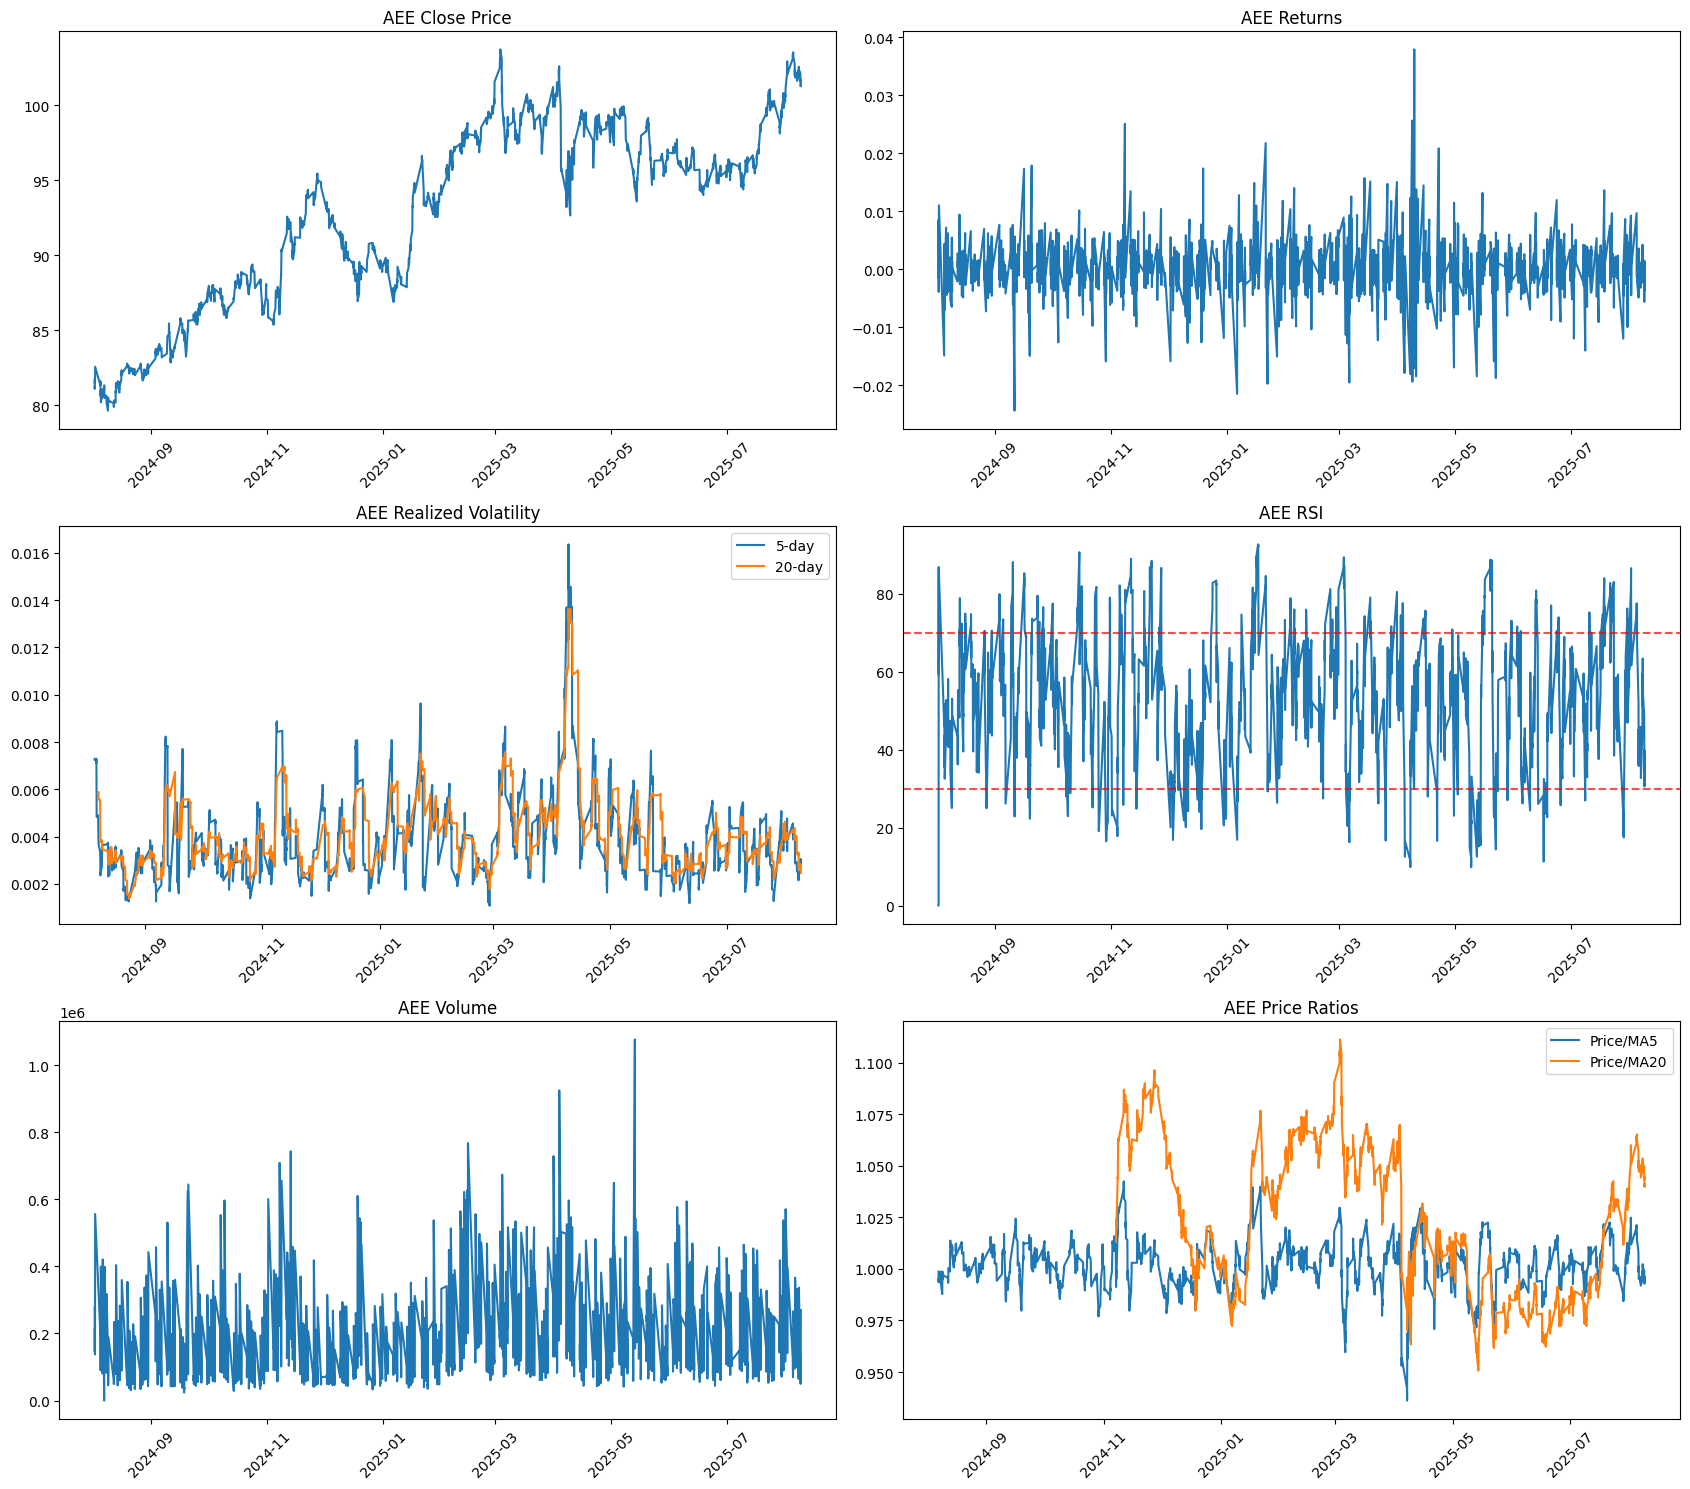

In [44]:
fig, axes = plt.subplots(3, 2, figsize=(17, 15))
#fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows), squeeze=False)

# Price and returns
axes[0,0].plot(sample_data['timestamp'], sample_data['close'])
axes[0,0].set_title(f'{sample_symbol} Close Price')
axes[0,0].tick_params(axis='x', rotation=45)

axes[0,1].plot(sample_data['timestamp'], sample_data['returns'])
axes[0,1].set_title(f'{sample_symbol} Returns')
axes[0,1].tick_params(axis='x', rotation=45)

# Volatility
axes[1,0].plot(sample_data['timestamp'], sample_data['realized_vol_short'], label='5-day')
axes[1,0].plot(sample_data['timestamp'], sample_data['realized_vol_med'], label='20-day')
axes[1,0].set_title(f'{sample_symbol} Realized Volatility')
axes[1,0].legend()
axes[1,0].tick_params(axis='x', rotation=45)

# RSI
axes[1,1].plot(sample_data['timestamp'], sample_data['rsi_ema'])
axes[1,1].axhline(y=70, color='r', linestyle='--', alpha=0.7)
axes[1,1].axhline(y=30, color='r', linestyle='--', alpha=0.7)
axes[1,1].set_title(f'{sample_symbol} RSI')
axes[1,1].tick_params(axis='x', rotation=45)

# Volume
axes[2,0].plot(sample_data['timestamp'], sample_data['volume'])
axes[2,0].set_title(f'{sample_symbol} Volume')
axes[2,0].tick_params(axis='x', rotation=45)

# Price ratios
axes[2,1].plot(sample_data['timestamp'], sample_data['price_to_ma_short'], label='Price/MA5')
axes[2,1].plot(sample_data['timestamp'], sample_data['price_to_ma_long'], label='Price/MA20')
axes[2,1].set_title(f'{sample_symbol} Price Ratios')
axes[2,1].legend()
axes[2,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Create Sequences for Training

## Configurations and Parameters

In [45]:
# Sequence creation parameters
SEQUENCE_LENGTH = 48        # 48 hours = 2 days of hourly data
TARGET_HORIZON = 1          # Reserve space for future prediction (not used for embeddings)
MIN_VALID_RATIO = 0.65      # Lowered from 0.95 due to long rolling windows (20-day MA, 2w RSI)

print("Sequence Parameters:")
print(f"Sequence Length: {SEQUENCE_LENGTH} hours")
print(f"Minimum Valid Data Ratio: {MIN_VALID_RATIO*100}%")
print(f"Target Horizon: {TARGET_HORIZON} hour(s)")  # Added for completeness

Sequence Parameters:
Sequence Length: 48 hours
Minimum Valid Data Ratio: 65.0%
Target Horizon: 1 hour(s)


## Data Preparation Function

In [46]:
def prepare_features_for_sequences(features_df):
    """Prepare feature data and get column information"""
    
    # Get feature columns (exclude non-numeric columns)
    feature_cols = features_df.select_dtypes(include=[np.number]).columns.tolist()
    
    # Remove columns we don't want in sequences
    exclude_cols = ['date']  # 'date' is often object type anyway, but good to be explicit
    feature_cols = [col for col in feature_cols if col not in exclude_cols]
    
    print(f"Feature Preparation:")
    print(f"Total columns in dataframe: {len(features_df.columns)}")
    print(f"Numeric feature columns: {len(feature_cols)}")
    print(f"Excluded columns: {exclude_cols}")  # Show what was excluded
    
    # Get symbol information  
    unique_symbols = features_df['symbol'].unique()
    print(f"Unique symbols: {len(unique_symbols)}")
    print(f"Date range: {features_df['timestamp'].min()} to {features_df['timestamp'].max()}")  # Added data range
    
    return feature_cols, unique_symbols

In [47]:
# Prepare features
feature_columns, symbols_list = prepare_features_for_sequences(features_df)
print(f"\n✅ Ready to process {len(symbols_list)} symbols with {len(feature_columns)} features")

# Quick sanity check
if len(feature_columns) == 0:
    print("❌ ERROR: No feature columns found!")
elif len(symbols_list) == 0:
    print("❌ ERROR: No symbols found!")
else:
    print(f"📊 Expected sequences per symbol: ~{len(features_df) // len(symbols_list) - SEQUENCE_LENGTH}")

Feature Preparation:
Total columns in dataframe: 100
Numeric feature columns: 97
Excluded columns: ['date']
Unique symbols: 37
Date range: 2024-08-02 08:00:00 to 2025-08-08 14:00:00

✅ Ready to process 37 symbols with 97 features
📊 Expected sequences per symbol: ~1725


## Data Quality Check Function

In [48]:
def check_sequence_quality(sequence_data, min_valid_ratio=MIN_VALID_RATIO):
    """Check if a sequence meets quality requirements"""
    
    # Handle empty data
    if sequence_data.empty:
        return False, 0.0
    
    total_values = sequence_data.size
    valid_values = sequence_data.count().sum()  # Count non-NaN values
    valid_ratio = valid_values / total_values if total_values > 0 else 0.0
    
    return valid_ratio >= min_valid_ratio, valid_ratio

In [49]:
# Test the quality check function
sample_symbol = features_df['symbol'].iloc[0]
sample_data = features_df[features_df['symbol'] == sample_symbol].head(SEQUENCE_LENGTH)

print(f"Testing with symbol: {sample_symbol}")
print(f"Sample data shape: {sample_data[feature_columns].shape}")

is_valid, ratio = check_sequence_quality(sample_data[feature_columns])
print(f"Sample quality check - Valid: {is_valid}, Ratio: {ratio:.3f}")

# Additional diagnostics
if not is_valid:
    print(f"❌ Quality check failed: {ratio:.1%} < {MIN_VALID_RATIO:.1%}")
    print(f"Need {(MIN_VALID_RATIO - ratio) * sample_data[feature_columns].size:.0f} more valid values")
else:
    print(f"✅ Quality check passed: {ratio:.1%} >= {MIN_VALID_RATIO:.1%}")

Testing with symbol: AEE
Sample data shape: (48, 97)
Sample quality check - Valid: True, Ratio: 0.676
✅ Quality check passed: 67.6% >= 65.0%


## NaN Handling Function

In [50]:
def clean_sequence_data(sequence_data):
    """Clean sequence data by handling NaN values with multiple strategies"""
    
    # Handle empty data
    if sequence_data.empty:
        return sequence_data.copy(), True
    
    sequence_clean = sequence_data.copy()
    initial_nans = sequence_clean.isnull().sum().sum()
    
    # Strategy 1: Forward fill then backward fill
    sequence_clean = sequence_clean.ffill().bfill()
    nans_after_fill = sequence_clean.isnull().sum().sum()
    
    # Strategy 2: If still NaNs, fill with column means
    if nans_after_fill > 0:
        column_means = sequence_clean.mean()
        # Only fill columns that have valid means (avoid NaN means)
        for col in sequence_clean.columns:
            if sequence_clean[col].isnull().any() and not pd.isna(column_means[col]):
                sequence_clean[col].fillna(column_means[col], inplace=True)
    
    nans_after_mean = sequence_clean.isnull().sum().sum()
    
    # Strategy 3: If still NaNs (shouldn't happen), fill with 0
    if nans_after_mean > 0:
        sequence_clean = sequence_clean.fillna(0)
        # Uncomment for debugging: print(f"Warning: {nans_after_mean} NaNs filled with 0 as last resort")
    
    # Final check
    remaining_nans = sequence_clean.isnull().sum().sum()
    
    return sequence_clean, remaining_nans == 0

In [51]:
# Enhanced test with more diagnostics
print(f"Original sample NaNs: {sample_data[feature_columns].isnull().sum().sum()}")

if sample_data[feature_columns].isnull().any().any():
    cleaned_sample, is_clean = clean_sequence_data(sample_data[feature_columns])
    print(f"After cleaning - NaNs: {cleaned_sample.isnull().sum().sum()}")
    print(f"Cleaning successful: {is_clean}")
    
    # Show which strategies were needed
    if is_clean:
        print("✅ All NaNs successfully handled")
    else:
        print(f"❌ {cleaned_sample.isnull().sum().sum()} NaNs remain")
        
else:
    print("✅ Sample data was already clean - no NaNs found")

# Verify data integrity
print(f"Sample shape maintained: {sample_data[feature_columns].shape} -> {cleaned_sample.shape if 'cleaned_sample' in locals() else 'N/A'}")

Original sample NaNs: 1510
After cleaning - NaNs: 0
Cleaning successful: True
✅ All NaNs successfully handled
Sample shape maintained: (48, 97) -> (48, 97)


In [52]:
cleaned_sample.head(5)

,open,high,low,close,volume,returns,log_returns,high_low_pct,open_close_pct,price_acceleration,...,bb_lower,bb_position,bb_squeeze,macd,macd_signal,macd_histogram,macd_normalized,atr,atr_normalized,williams_r
0,82.670,83.83,80.93,81.220,278258,-0.001477,-0.001479,0.035705,-0.017540,0.009985,...,80.083849,0.5,0.025464,0.000000,0.000000,0.000000,0.000000,0.9625,0.011916,-99.29078
1,81.260,82.10,80.96,81.100,173868,-0.001477,-0.001479,0.014057,-0.001969,0.009985,...,80.083849,0.5,0.025464,-0.002692,-0.001496,-0.001197,-0.000033,0.9625,0.011916,-99.29078
2,81.110,81.94,80.76,81.790,144352,0.008508,0.008472,0.014427,0.008384,0.009985,...,80.083849,0.5,0.025464,0.017966,0.006481,0.011486,0.000220,0.9625,0.011916,-99.29078
3,81.815,81.90,81.27,81.470,215518,-0.003912,-0.003920,0.007733,-0.004217,-0.012420,...,80.083849,0.5,0.025464,0.015368,0.009491,0.005877,0.000189,0.9625,0.011916,-99.29078
4,81.440,81.82,81.28,81.635,137657,0.002025,0.002023,0.006615,0.002394,0.005938,...,80.083849,0.5,0.025464,0.020199,0.012677,0.007522,0.000247,0.9625,0.011916,-99.29078


## Symbol Processing

In [53]:
def create_sequences_streamlined(features_df, feature_cols, sequence_length=SEQUENCE_LENGTH, 
                               stride=1, min_valid_ratio=MIN_VALID_RATIO):
    """Streamlined sequence creation using your tested functions"""
    
    print(f"Creating sequences with length {sequence_length}")
    print(f"Using minimum valid ratio: {min_valid_ratio}")
    
    sequences = []
    symbols_list = []
    timestamps_list = []
    total_skipped = 0
    
    for symbol in tqdm(features_df['symbol'].unique(), desc="Processing symbols"):
        symbol_data = features_df[features_df['symbol'] == symbol].sort_values('timestamp')
        
        # Skip if insufficient data
        if len(symbol_data) < sequence_length:
            continue
            
        # Create sequences with stride
        for start_idx in range(0, len(symbol_data) - sequence_length + 1, stride):
            window = symbol_data[feature_cols].iloc[start_idx:start_idx + sequence_length]
            
            # Use your tested quality check function
            is_valid, valid_ratio = check_sequence_quality(window, min_valid_ratio)
            
            if not is_valid:
                total_skipped += 1
                continue
                
            # Use your tested cleaning function
            window_clean, is_clean = clean_sequence_data(window)
            
            if not is_clean:
                total_skipped += 1
                continue
            
            # Add valid sequence
            sequences.append(window_clean.values)
            symbols_list.append(symbol)
            timestamps_list.append(symbol_data['timestamp'].iloc[start_idx + sequence_length - 1])
    
    sequences_array = np.array(sequences, dtype=np.float32)
    print(f"✅ Created {len(sequences_array)} sequences of shape {sequences_array.shape}")
    print(f"⚠️  Skipped {total_skipped} sequences due to quality issues")
    
    return sequences_array, symbols_list, timestamps_list

In [54]:
# Use it with your existing tested parameters
sequences, sequence_symbols, sequence_timestamps = create_sequences_streamlined(
    features_df, 
    feature_cols=feature_columns,  # Use your prepared feature columns
    sequence_length=SEQUENCE_LENGTH,
    min_valid_ratio=MIN_VALID_RATIO
)

Creating sequences with length 48
Using minimum valid ratio: 0.65


Processing symbols: 100%|██████████| 37/37 [52:35<00:00, 85.29s/it] 


✅ Created 63862 sequences of shape (63862, 48, 97)
⚠️  Skipped 0 sequences due to quality issues


## Feature Normalization

## Updated Normalization

In [55]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [62]:
def detect_and_handle_outliers(sequences, feature_columns, method='iqr', factor=3.0):
    """
    Detect and handle extreme outliers before normalization
    
    Parameters:
    -----------
    sequences : np.array
        Shape (n_sequences, sequence_length, n_features)
    feature_columns : list
        Feature names
    method : str
        'iqr' for IQR method, 'zscore' for Z-score method
    factor : float
        Multiplier for outlier detection (3.0 = 3 IQRs or 3 standard deviations)
    """
    
    print(f"🔍 OUTLIER DETECTION AND HANDLING ({method.upper()} method)")
    print("=" * 50)
    
    sequences_clean = sequences.copy()
    outlier_stats = {}
    
    for feat_idx, feature_name in enumerate(feature_columns):
        # Get all values for this feature across all sequences
        feature_data = sequences[:, :, feat_idx].flatten()
        original_count = len(feature_data)
        finite_data = feature_data[np.isfinite(feature_data)]
        
        print(f"\n📊 {feature_name}:")
        #print(f"   Original range: [{np.min(finite_data):.2f}, {np.max(finite_data):.2f}]")
        
        if method == 'iqr':
            Q1 = np.percentile(finite_data, 25)
            Q3 = np.percentile(finite_data, 75)
            IQR = Q3 - Q1
            lower_bound = Q1 - factor * IQR
            upper_bound = Q3 + factor * IQR
            
        elif method == 'zscore':
            mean_val = np.mean(finite_data)
            std_val = np.std(finite_data)
            lower_bound = mean_val - factor * std_val
            upper_bound = mean_val + factor * std_val
        
        # Count outliers
        outliers = (finite_data < lower_bound) | (finite_data > upper_bound)
        outlier_count = np.sum(outliers)
        outlier_percentage = (outlier_count / len(finite_data)) * 100
        
        #print(f"   Outlier bounds: [{lower_bound:.2f}, {upper_bound:.2f}]")
        print(f"   Outliers found: {outlier_count:,} ({outlier_percentage:.2f}%)")
        
        # Handle outliers by clipping
        sequences_clean[:, :, feat_idx] = np.clip(
            sequences_clean[:, :, feat_idx], 
            lower_bound, 
            upper_bound
        )
        
        # Store stats
        outlier_stats[feature_name] = {
            'outlier_count': outlier_count,
            'outlier_percentage': outlier_percentage,
            'lower_bound': lower_bound,
            'upper_bound': upper_bound,
            'original_range': (np.min(finite_data), np.max(finite_data))
        }
    
    print(f"\n✅ Outlier handling complete!")
    return sequences_clean, outlier_stats

In [63]:
def normalize_sequences_improved(sequences, feature_columns, method='robust_global'):
    """
    Improved normalization with multiple strategies
    
    Parameters:
    -----------
    sequences : np.array
        Shape (n_sequences, sequence_length, n_features)  
    feature_columns : list
        Feature names
    method : str
        'robust_global': Global robust scaling (recommended)
        'standard_global': Global standard scaling
        'minmax_global': Global min-max scaling
        'per_sequence': Your original per-sequence method (not recommended)
    """
    
    print(f"🎯 IMPROVED NORMALIZATION ({method})")
    print("=" * 40)
    
    n_sequences, seq_length, n_features = sequences.shape
    normalized_sequences = sequences.copy()
    normalization_params = {}
    
    if 'global' in method:
        # Global normalization - fit on all data to maintain consistency
        print("Using GLOBAL normalization (recommended for deep learning)")
        
        for feat_idx, feature_name in enumerate(feature_columns):
            # Get all values for this feature
            feature_data = sequences[:, :, feat_idx].flatten()
            feature_data = feature_data[np.isfinite(feature_data)]  # Remove NaN/inf
            
            if len(feature_data) == 0:
                print(f"⚠️  No valid data for {feature_name}, skipping...")
                continue
            
            if method == 'robust_global':
                # Robust scaling (median and IQR)
                median_val = np.median(feature_data)
                q75, q25 = np.percentile(feature_data, [75, 25])
                iqr = q75 - q25
                
                if iqr > 1e-10:
                    normalized_sequences[:, :, feat_idx] = (sequences[:, :, feat_idx] - median_val) / iqr
                    scale_factor = iqr
                    center_val = median_val
                else:
                    normalized_sequences[:, :, feat_idx] = sequences[:, :, feat_idx] - median_val
                    scale_factor = 1.0
                    center_val = median_val
                
            elif method == 'standard_global':
                # Standard scaling (mean and std)
                mean_val = np.mean(feature_data)
                std_val = np.std(feature_data)
                
                if std_val > 1e-10:
                    normalized_sequences[:, :, feat_idx] = (sequences[:, :, feat_idx] - mean_val) / std_val
                    scale_factor = std_val
                    center_val = mean_val
                else:
                    normalized_sequences[:, :, feat_idx] = sequences[:, :, feat_idx] - mean_val
                    scale_factor = 1.0
                    center_val = mean_val
                    
            elif method == 'minmax_global':
                # Min-max scaling
                min_val = np.min(feature_data)
                max_val = np.max(feature_data)
                
                if max_val - min_val > 1e-10:
                    normalized_sequences[:, :, feat_idx] = (sequences[:, :, feat_idx] - min_val) / (max_val - min_val)
                    scale_factor = max_val - min_val
                    center_val = min_val
                else:
                    normalized_sequences[:, :, feat_idx] = 0.5
                    scale_factor = 1.0
                    center_val = min_val
            
            # Store normalization parameters
            normalization_params[feature_name] = {
                'center': center_val,
                'scale': scale_factor,
                'method': method
            }
            
            print(f"   {feature_name}: center={center_val:.4f}, scale={scale_factor:.4f}")
    
    else:  # per_sequence method (your original)
        print("Using PER-SEQUENCE normalization (may cause issues)")
        # Your original implementation here...
        pass
    
    print(f"✅ Normalization complete using {method} method!")
    return normalized_sequences, normalization_params

In [64]:
def validate_normalization_improved(original_sequences, normalized_sequences, feature_columns):
    """
    Enhanced validation with detailed diagnostics
    """
    print("\n🔍 ENHANCED NORMALIZATION VALIDATION")
    print("=" * 45)
    
    # Basic validation
    nan_count = np.isnan(normalized_sequences).sum()
    inf_count = np.isinf(normalized_sequences).sum()
    
    print(f"✅ NaN values: {nan_count} ({'❌ PROBLEM' if nan_count > 0 else '✅ Good'})")
    print(f"✅ Inf values: {inf_count} ({'❌ PROBLEM' if inf_count > 0 else '✅ Good'})")
    
    # Detailed statistics
    orig_mean = np.nanmean(original_sequences)
    orig_std = np.nanstd(original_sequences)
    orig_min = np.nanmin(original_sequences)
    orig_max = np.nanmax(original_sequences)
    
    norm_mean = np.nanmean(normalized_sequences)
    norm_std = np.nanstd(normalized_sequences)
    norm_min = np.nanmin(normalized_sequences)
    norm_max = np.nanmax(normalized_sequences)
    
    print(f"\n📊 Before normalization:")
    print(f"   Mean: {orig_mean:.4f}")
    print(f"   Std:  {orig_std:.4f}")
    print(f"   Range: [{orig_min:.4f}, {orig_max:.4f}]")
    
    print(f"\n📊 After normalization:")
    print(f"   Mean: {norm_mean:.4f}")
    print(f"   Std:  {norm_std:.4f}")
    print(f"   Range: [{norm_min:.4f}, {norm_max:.4f}]")
    
    # Quality assessment
    print(f"\n🎯 QUALITY ASSESSMENT:")
    
    # Check if normalization was effective
    if abs(norm_mean) < 0.1 and 0.5 < norm_std < 2.0:
        print("✅ EXCELLENT: Well-normalized data")
    elif abs(norm_mean) < 0.5 and 0.2 < norm_std < 5.0:
        print("✅ GOOD: Reasonably normalized data")
    elif abs(norm_std) > 10:
        print("❌ POOR: High variance - outliers may still be present")
    else:
        print("⚠️  FAIR: Normalization could be improved")
    
    # Check for extreme values
    if abs(norm_min) > 50 or abs(norm_max) > 50:
        print("❌ EXTREME VALUES: Consider outlier removal")
    else:
        print("✅ VALUE RANGE: No extreme outliers detected")
    
    # Per-feature analysis
    print(f"\n📋 PER-FEATURE ANALYSIS:")
    for i, feature in enumerate(feature_columns):
        feat_data = normalized_sequences[:, :, i].flatten()
        feat_mean = np.nanmean(feat_data)
        feat_std = np.nanstd(feat_data)
        feat_min = np.nanmin(feat_data)
        feat_max = np.nanmax(feat_data)
        
        print(f"   {feature[:20]:20}: μ={feat_mean:6.3f}, σ={feat_std:6.3f}, range=[{feat_min:7.2f}, {feat_max:7.2f}]")
    
    return nan_count == 0 and inf_count == 0

In [65]:
def plot_normalization_comparison(original, normalized, feature_columns, n_features=4):
    """
    Visual comparison of normalization effects
    """
    fig, axes = plt.subplots(3, n_features, figsize=(16, 12))
    fig.suptitle('🎯 Normalization Comparison', fontsize=16, fontweight='bold')
    
    for i in range(min(n_features, len(feature_columns))):
        feature_name = feature_columns[i]
        
        # Original data
        orig_data = original[:, :, i].flatten()
        orig_data = orig_data[np.isfinite(orig_data)]
        
        # Normalized data  
        norm_data = normalized[:, :, i].flatten()
        norm_data = norm_data[np.isfinite(norm_data)]
        
        # Histograms
        axes[0, i].hist(orig_data, bins=50, alpha=0.7, color='red', density=True)
        axes[0, i].set_title(f'Original: {feature_name[:15]}', fontweight='bold')
        axes[0, i].set_ylabel('Density')
        
        axes[1, i].hist(norm_data, bins=50, alpha=0.7, color='green', density=True)
        axes[1, i].set_title(f'Normalized: {feature_name[:15]}', fontweight='bold')
        axes[1, i].set_ylabel('Density')
        
        # Box plots
        axes[2, i].boxplot([orig_data, norm_data], labels=['Original', 'Normalized'])
        axes[2, i].set_title(f'Box Plot: {feature_name[:15]}', fontweight='bold')
        axes[2, i].set_xlabel('Data Type')
    
    plt.tight_layout()
    plt.show()

In [66]:
# RECOMMENDED WORKFLOW
def fix_normalization_pipeline(sequences, feature_columns):
    """
    Complete pipeline to fix your normalization issues
    """
    print("🚀 COMPLETE NORMALIZATION FIX PIPELINE")
    print("=" * 50)
    
    # Step 1: Handle outliers
    print("\n1️⃣ Handling extreme outliers...")
    sequences_clean, outlier_stats = detect_and_handle_outliers(
        sequences, feature_columns, method='iqr', factor=3.0
    )
    
    # Step 2: Apply improved normalization
    print("\n2️⃣ Applying improved normalization...")
    sequences_normalized, norm_params = normalize_sequences_improved(
        sequences_clean, feature_columns, method='robust_global'
    )
    
    # Step 3: Validate results
    print("\n3️⃣ Validating results...")
    is_valid = validate_normalization_improved(
        sequences, sequences_normalized, feature_columns
    )
    
    # Step 4: Visualize comparison
    print("\n4️⃣ Generating comparison plots...")
    plot_normalization_comparison(sequences, sequences_normalized, feature_columns)
    
    return sequences_normalized, norm_params, outlier_stats, is_valid

🚀 COMPLETE NORMALIZATION FIX PIPELINE

1️⃣ Handling extreme outliers...
🔍 OUTLIER DETECTION AND HANDLING (IQR method)

📊 open:
   Outliers found: 29,496 (0.96%)

📊 high:
   Outliers found: 29,688 (0.97%)

📊 low:
   Outliers found: 29,112 (0.95%)

📊 close:
   Outliers found: 29,304 (0.96%)

📊 volume:
   Outliers found: 139,594 (4.55%)

📊 returns:
   Outliers found: 74,516 (2.43%)

📊 log_returns:
   Outliers found: 74,302 (2.42%)

📊 high_low_pct:
   Outliers found: 83,556 (2.73%)

📊 open_close_pct:
   Outliers found: 55,114 (1.80%)

📊 price_acceleration:
   Outliers found: 62,495 (2.04%)

📊 returns_sign:
   Outliers found: 0 (0.00%)

📊 returns_squared:
   Outliers found: 261,302 (8.52%)

📊 realized_vol_short:
   Outliers found: 92,853 (3.03%)

📊 realized_vol_med:
   Outliers found: 107,639 (3.51%)

📊 realized_vol_long:
   Outliers found: 104,466 (3.41%)

📊 gk_volatility:
   Outliers found: 100,988 (3.29%)

📊 vol_of_vol:
   Outliers found: 120,719 (3.94%)

📊 price_ma_short:
   Outliers fo

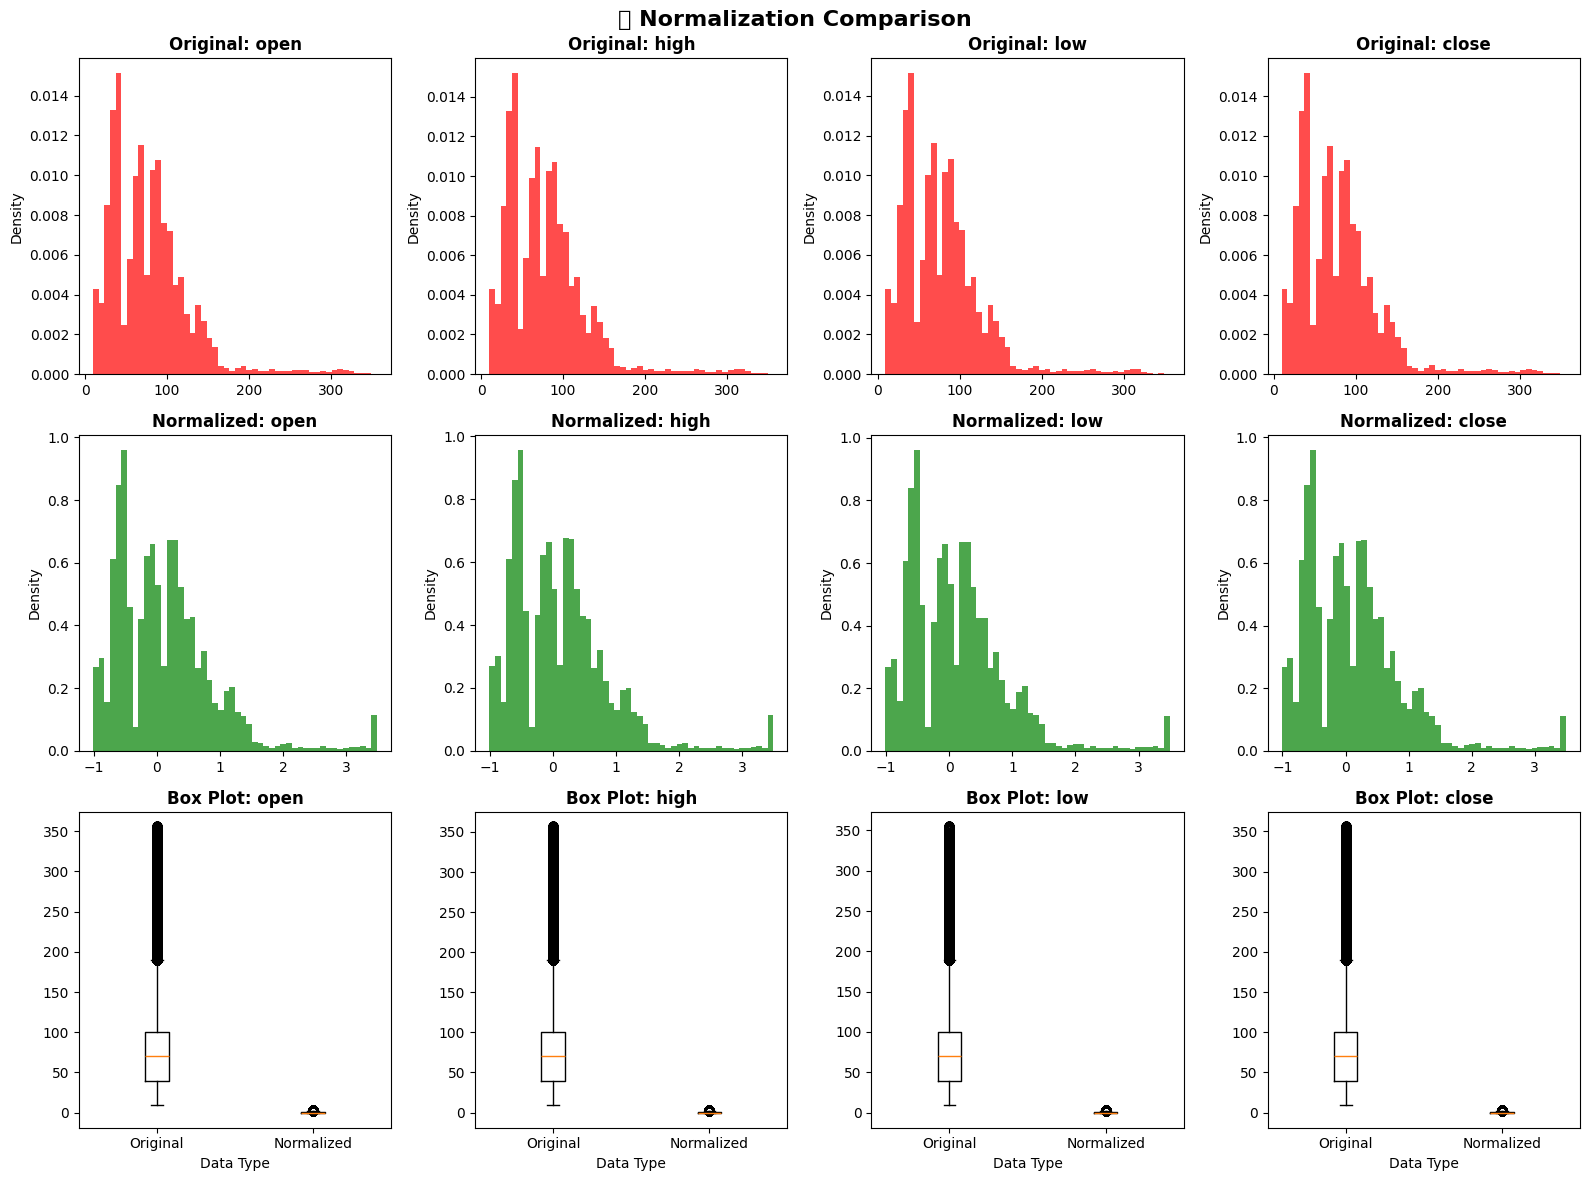

In [67]:
# Replace your normalization with this:
sequences_fixed, norm_params, outlier_stats, is_valid = fix_normalization_pipeline(
    sequences, feature_columns
)

In [68]:
# Convert to PyTorch tensor
if is_valid:
    sequences_tensor = torch.FloatTensor(sequences_fixed)
    print(f"🎉 Ready for GRU training: {sequences_tensor.shape}")
else:
    print("❌ Normalization issues need to be resolved before training!")


🎉 Ready for GRU training: torch.Size([63862, 48, 97])


# Do Not Run after this

## Visualization

In [ ]:
def analyze_sequences_comprehensive(sequences, feature_columns, sequence_symbols, sequence_timestamps):
    """
    Comprehensive analysis of your sequences
    """
    print("🔍 SEQUENCE ANALYSIS REPORT")
    print("=" * 50)
    
    # Basic stats
    n_sequences, seq_length, n_features = sequences.shape
    print(f"📊 Dataset Overview:")
    print(f"   • Total sequences: {n_sequences:,}")
    print(f"   • Sequence length: {seq_length} hours")
    print(f"   • Number of features: {n_features}")
    print(f"   • Total data points: {n_sequences * seq_length * n_features:,}")
    
    # Symbol distribution
    symbol_counts = pd.Series(sequence_symbols).value_counts()
    print(f"\n📈 Symbol Distribution:")
    print(f"   • Unique symbols: {len(symbol_counts)}")
    print(f"   • Sequences per symbol: {symbol_counts.mean():.1f} ± {symbol_counts.std():.1f}")
    print(f"   • Min/Max sequences: {symbol_counts.min()}/{symbol_counts.max()}")
    
    # Data quality
    total_values = sequences.size
    finite_values = np.isfinite(sequences).sum()
    print(f"\n✅ Data Quality:")
    print(f"   • Finite values: {finite_values:,}/{total_values:,} ({finite_values/total_values*100:.2f}%)")
    print(f"   • NaN values: {np.isnan(sequences).sum():,}")
    print(f"   • Infinite values: {np.isinf(sequences).sum():,}")
    
    # Feature statistics
    #print(f"\n📋 Feature Statistics:")
    #for i, feature in enumerate(feature_columns):
    #    feature_data = sequences[:, :, i]
    #    print(f"   • {feature}:")
    #    print(f"     - Range: [{np.nanmin(feature_data):.4f}, {np.nanmax(feature_data):.4f}]")
    #    print(f"     - Mean: {np.nanmean(feature_data):.4f} ± {np.nanstd(feature_data):.4f}")
    
    return symbol_counts

In [ ]:
def plot_sequence_overview(sequences, feature_columns, sequence_symbols):
    """
    Create overview plots of your sequences
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('📊 Sequence Dataset Overview', fontsize=16, fontweight='bold', y=0.98)
    
    # 1. Sequence length distribution (if varies)
    ax1 = axes[0, 0]
    seq_lengths = [sequences.shape[1]] * sequences.shape[0]  # All same length in your case
    ax1.bar(['Sequence Length'], [sequences.shape[1]], color='skyblue', alpha=0.7)
    ax1.set_title('Sequence Length Distribution', fontweight='bold')
    ax1.set_ylabel('Hours')
    ax1.text(0, sequences.shape[1]/2, f'{sequences.shape[1]}h\n(2 days)', 
             ha='center', va='center', fontweight='bold', fontsize=12)
    
    # 2. Symbol frequency
    ax2 = axes[0, 1]
    symbol_counts = pd.Series(sequence_symbols).value_counts()
    top_10_symbols = symbol_counts.head(10)
    ax2.bar(range(len(top_10_symbols)), top_10_symbols.values, color='lightgreen', alpha=0.7)
    ax2.set_title('Top 10 Symbols by Sequence Count', fontweight='bold')
    ax2.set_xlabel('Symbols')
    ax2.set_ylabel('Number of Sequences')
    ax2.set_xticks(range(len(top_10_symbols)))
    ax2.set_xticklabels(top_10_symbols.index, rotation=45)
    
    # 3. Feature value distributions
    ax3 = axes[1, 0]
    feature_means = []
    feature_stds = []
    for i in range(len(feature_columns)):
        feature_data = sequences[:, :, i].flatten()
        feature_means.append(np.nanmean(feature_data))
        feature_stds.append(np.nanstd(feature_data))
    
    x_pos = np.arange(len(feature_columns))
    ax3.bar(x_pos, feature_means, yerr=feature_stds, capsize=3, color='orange', alpha=0.7)
    ax3.set_title('Feature Means ± Std Dev', fontweight='bold')
    ax3.set_xlabel('Features')
    ax3.set_ylabel('Values')
    ax3.set_xticks(x_pos)
    ax3.set_xticklabels([f'F{i+1}' for i in range(len(feature_columns))], rotation=45)
    
    # 4. Data completeness heatmap
    ax4 = axes[1, 1]
    # Calculate completeness per feature per sequence (sample)
    sample_sequences = min(20, sequences.shape[0])
    completeness = np.zeros((sample_sequences, len(feature_columns)))
    for i in range(sample_sequences):
        for j in range(len(feature_columns)):
            completeness[i, j] = np.isfinite(sequences[i, :, j]).mean()
    
    im = ax4.imshow(completeness, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
    ax4.set_title(f'Data Completeness\n(Sample of {sample_sequences} sequences)', fontweight='bold')
    ax4.set_xlabel('Features')
    ax4.set_ylabel('Sequences')
    ax4.set_xticks(range(len(feature_columns)))
    ax4.set_xticklabels([f'F{i+1}' for i in range(len(feature_columns))])
    
    # Add colorbar
    plt.colorbar(im, ax=ax4, fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_sample_sequences(sequences, feature_columns, n_samples=4):
    """
    Plot sample sequences to understand the data patterns
    """
    fig, axes = plt.subplots(n_samples, 1, figsize=(15, 3*n_samples))
    if n_samples == 1:
        axes = [axes]
    
    fig.suptitle('🔍 Sample Sequence Patterns', fontsize=16, fontweight='bold', y=0.98)
    
    # Select random sequences
    sample_indices = np.random.choice(sequences.shape[0], n_samples, replace=False)
    
    for i, seq_idx in enumerate(sample_indices):
        ax = axes[i]
        sequence_data = sequences[seq_idx]  # Shape: (48, n_features)
        
        # Plot each feature
        for feat_idx in range(min(5, len(feature_columns))):  # Limit to 5 features for readability
            ax.plot(sequence_data[:, feat_idx], 
                   label=f'{feature_columns[feat_idx][:15]}...', 
                   linewidth=1.5, alpha=0.8)
        
        ax.set_title(f'Sequence #{seq_idx} - 48 Hour Window', fontweight='bold')
        ax.set_xlabel('Hours')
        ax.set_ylabel('Normalized Values')
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.grid(True, alpha=0.3)
        ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_feature_correlations(sequences, feature_columns):
    """
    Analyze correlations between features
    """
    # Flatten sequences to get all data points
    n_sequences, seq_length, n_features = sequences.shape
    flattened_data = sequences.reshape(-1, n_features)
    
    # Create correlation matrix
    corr_df = pd.DataFrame(flattened_data, columns=feature_columns)
    correlation_matrix = corr_df.corr()
    
    # Plot heatmap
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    sns.heatmap(correlation_matrix, 
                mask=mask, 
                annot=True, 
                cmap='RdBu_r', 
                center=0,
                square=True,
                fmt='.2f',
                cbar_kws={"shrink": .8})
    
    plt.title('🔗 Feature Correlation Matrix', fontsize=16, fontweight='bold', pad=20)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # Print highly correlated pairs
    print("🔗 Highly Correlated Feature Pairs (|r| > 0.7):")
    print("-" * 50)
    high_corr_pairs = []
    for i in range(len(feature_columns)):
        for j in range(i+1, len(feature_columns)):
            corr_val = correlation_matrix.iloc[i, j]
            if abs(corr_val) > 0.7:
                high_corr_pairs.append((feature_columns[i], feature_columns[j], corr_val))
    
    if high_corr_pairs:
        for feat1, feat2, corr in sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True):
            print(f"   • {feat1} ↔ {feat2}: {corr:.3f}")
    else:
        print("   • No highly correlated pairs found")

In [ ]:
def plot_normalization_effects(original_sequences, normalized_sequences, feature_columns):
    """
    Compare before and after normalization
    """
    n_features = len(feature_columns)
    fig, axes = plt.subplots(2, min(4, n_features), figsize=(16, 8))
    if n_features == 1:
        axes = axes.reshape(2, 1)
    
    fig.suptitle('🎯 Normalization Effects (Before vs After)', fontsize=16, fontweight='bold', y=0.98)
    
    for i in range(min(4, n_features)):
        # Before normalization
        original_data = original_sequences[:, :, i].flatten()
        axes[0, i].hist(original_data, bins=50, alpha=0.7, color='red', density=True)
        axes[0, i].set_title(f'Before: {feature_columns[i][:15]}...', fontweight='bold')
        axes[0, i].set_ylabel('Density')
        axes[0, i].text(0.02, 0.98, f'μ={np.nanmean(original_data):.2f}\nσ={np.nanstd(original_data):.2f}', 
                       transform=axes[0, i].transAxes, va='top', fontsize=10,
                       bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
        
        # After normalization
        normalized_data = normalized_sequences[:, :, i].flatten()
        axes[1, i].hist(normalized_data, bins=50, alpha=0.7, color='green', density=True)
        axes[1, i].set_title(f'After: {feature_columns[i][:15]}...', fontweight='bold')
        axes[1, i].set_xlabel('Value')
        axes[1, i].set_ylabel('Density')
        axes[1, i].text(0.02, 0.98, f'μ={np.nanmean(normalized_data):.2f}\nσ={np.nanstd(normalized_data):.2f}', 
                       transform=axes[1, i].transAxes, va='top', fontsize=10,
                       bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
    
    plt.tight_layout()
    plt.show()

In [ ]:
print("\n" + "="*60)
print("📈 SEQUENCE DATASET ANALYSIS COMPLETE")
print("="*60)

In [ ]:
# Run all analyses
print("\n1️⃣ Running comprehensive analysis...")
symbol_counts = analyze_sequences_comprehensive(sequences, feature_columns, sequence_symbols, sequence_timestamps)

In [ ]:
print("\n2️⃣ Generating overview plots...")
plot_sequence_overview(sequences, feature_columns, sequence_symbols)

In [ ]:
print("\n3️⃣ Plotting sample sequences...")
plot_sample_sequences(sequences, feature_columns)

In [ ]:
print("\n4️⃣ Analyzing feature correlations...")
plot_feature_correlations(sequences, feature_columns)

In [ ]:
# If you want to compare normalization effects:
plot_normalization_effects(sequences, normalized_sequences, feature_columns)

In [ ]:
# Summary recommendations
print("\n🎯 RECOMMENDATIONS FOR GRU TRAINING:")
print("-" * 40)
print(f"✅ Dataset size: {sequences.shape[0]:,} sequences is good for training")
print(f"✅ Sequence length: {sequences.shape[1]} hours captures short-term patterns")
print(f"✅ Feature count: {sequences.shape[2]} features - consider dimensionality")
print(f"💡 Consider batch size: {min(32, sequences.shape[0]//10)} - {min(128, sequences.shape[0]//5)}")
print(f"💡 Train/Val split suggestion: 80/20 = {int(sequences.shape[0]*0.8)}/{int(sequences.shape[0]*0.2)}")

if sequences.shape[2] > 20:
    print("⚠️  Consider feature selection or PCA - many features may cause overfitting")

### Optional: Quick data validation function

In [ ]:
def validate_sequences_for_training(sequences_tensor):
    """
    Final validation before GRU training
    """
    print("🔍 FINAL VALIDATION FOR GRU TRAINING")
    print("=" * 40)
    
    # Check tensor properties
    print(f"✅ Tensor shape: {sequences_tensor.shape}")
    print(f"✅ Tensor dtype: {sequences_tensor.dtype}")
    print(f"✅ Device: {sequences_tensor.device}")
    
    # Check for problematic values
    has_nan = torch.isnan(sequences_tensor).any()
    has_inf = torch.isinf(sequences_tensor).any()
    
    print(f"✅ NaN values: {'❌ FOUND' if has_nan else '✅ None'}")
    print(f"✅ Inf values: {'❌ FOUND' if has_inf else '✅ None'}")
    
    # Value ranges
    min_val = torch.min(sequences_tensor)
    max_val = torch.max(sequences_tensor)
    mean_val = torch.mean(sequences_tensor)
    std_val = torch.std(sequences_tensor)
    
    print(f"✅ Value range: [{min_val:.4f}, {max_val:.4f}]")
    print(f"✅ Mean ± Std: {mean_val:.4f} ± {std_val:.4f}")
    
    # Memory usage
    memory_mb = sequences_tensor.numel() * sequences_tensor.element_size() / (1024**2)
    print(f"✅ Memory usage: {memory_mb:.1f} MB")
    
    if has_nan or has_inf:
        print("❌ TENSOR NOT READY FOR TRAINING!")
        return False
    else:
        print("🎉 TENSOR READY FOR GRU TRAINING!")
        return True



In [ ]:
# Example usage:
is_ready = validate_sequences_for_training(sequences_tensor)

### Save